# Computational Finance Research Notebook

#### Load data and Packages

In [2]:
#Load libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import * 

In [3]:
#Load data in
tickers = ["TSLA", "AAPL", "AMD"]
start = "2020-01-01"
end = "2024-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

[*********************100%***********************]  3 of 3 completed


### Signal 1: Moving Average Crossover with MACD Indicator

#### A) Define signal

In [3]:
def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig, _ = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig, _ = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig, macd_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

#### B) Gridsearch best parameters for training set

For the parameter space we choose these parameters because in this literature ...

In [46]:
param_grid = {
    'short_ma': [10, 20, 30, 40, 50],
    'long_ma': [55, 75, 100, 125, 150, 175, 200],
    'short_macd': [12],
    'long_macd': [26],
    'signal_window_macd': [9]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, best_metrics, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal01, metric='sharpe')
    all_best_params[ticker] = best_params
    #pd.set_option('display.width', 200)
    #pd.set_option('display.max_columns', None)
    #print(f"\n=== Results for {ticker} ===")
    #print(results_df.head(5))


=== Results for TSLA ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret    sharpe    max_dd  volatility
0        50      125          12         26                   9  6.769636  1.012590  0.669353    0.035286
1        50      100          12         26                   9  5.985957  0.987173  0.650464    0.034397
2        40      125          12         26                   9  5.574169  0.953709  0.672695    0.035192
3        40       55          12         26                   9  5.068319  0.941884  0.666146    0.033807
4        50      150          12         26                   9  4.970771  0.918768  0.683570    0.035231

=== Results for AAPL ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret    sharpe    max_dd  volatility
0        50      200          12         26                   9  2.734213  1.242370  0.279492    0.014806
1        30      100          12         26                   9  2.601697  1.176439  0.267464    0.0

#### C) Evaluate best parameters on test set

We decide to evalute the best parameters on the 2020 to 2024 market regime because...

In [ ]:
test_start = "2020-01-01"
test_end = "2024-12-31"

test_df_prices, test_df_changes = download_stock_price_data(tickers, test_start, test_end)

In [ ]:
test_results = {}
for ticker in tickers:
    price = test_df_prices[ticker]
    signals = signal01(price = prices, **all_best_params[ticker])
    cumret, sharpe_val, max_dd, volatility = backtest_strategy(price, signals)
    test_results[ticker] = {'Signal Sharpe': sharpe_val, 'BuyHold Sharpe': buy_hold_sharpe, 'Sharpe Delta': sharpe_val - buy_hold_sharpe, 'Cumulative Return': cumret[-1], 'Max Drawdown': max_dd,'Volatility': volatility}
    

#### D) Assesment

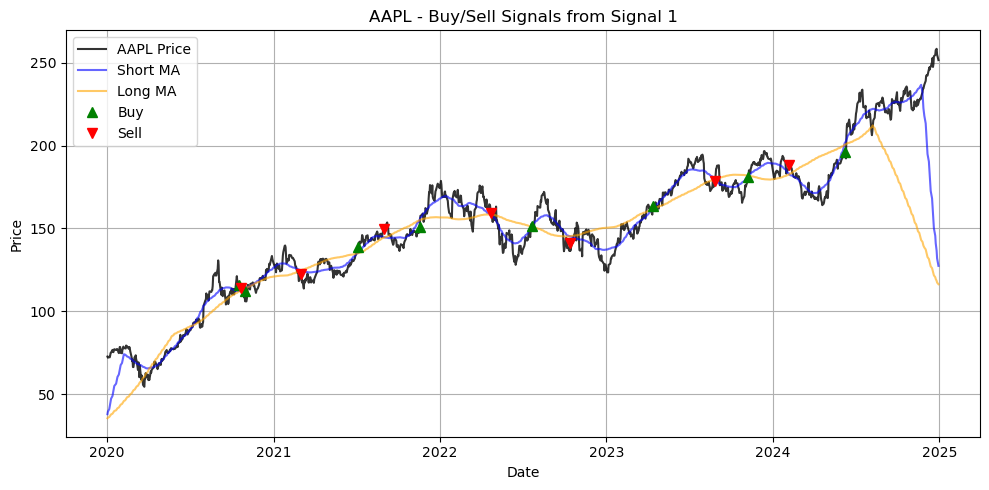

In [4]:
#Best params
short_ma = 50
long_ma = 200
short_macd = 12
long_macd = 26
signal_window_macd = 9

ticker = "AAPL"
price = df_prices[ticker]
#signals = signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd)
_ , signals = ma_signal(price, short_ma, long_ma)
#_ , signals = signal_macd(prices, short_macd, long_macd, signal_window_macd)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(price, label=f"{ticker} Price", color='black', alpha=0.8)
plt.plot(signals['short_ma'], label='Short MA', color='blue', alpha=0.6)
plt.plot(signals['long_ma'], label='Long MA', color='orange', alpha=0.6)

#plt.plot(signals['signal_line'], label='EMA', color='blue', alpha=0.6)
#plt.plot(signals['MACD'], label='MACD', color='orange', alpha=0.6)

# Buy/Sell points
buy = signals['position_change'] == 1
sell = signals['position_change'] == -1
plt.plot(price[buy], 'g^', label='Buy', markersize=7)
plt.plot(price[sell], 'rv', label='Sell', markersize=7)

plt.title(f"{ticker} - Buy/Sell Signals from Signal 1")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
tickers = ["TSLA", "AAPL", "AMD"]
start = "2010-01-01"
end = "2019-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

### Signal 2: RSI with Bollinger Bands

#### Define signal

In [6]:
def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig, _ = signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig, _ = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig, bollinger_sig)

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)

    return signals

#### Gridsearch Best Parameters

In [8]:
param_grid = {
    'rsi_window_length': [10, 14],
    'lower_rsi_bound': [30, 40],
    'upper_rsi_bound': [60, 70],
    'bollinger_window_length': [10, 14],
    'bollinger_n_stds': [1, 1.5, 2]
}

for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, best_metrics, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal02, metric='cumret')
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(5))


=== Results for TSLA ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds    cumret    sharpe    max_dd  volatility
0                 14               30               60                       14               1.0  3.556598  1.983675  0.359896    0.027187
1                 14               40               60                       14               1.0  3.061882  1.801107  0.379489    0.028142
2                 10               30               60                       14               1.0  2.744878  1.777227  0.409057    0.026723
3                 14               30               70                       14               1.0  2.179210  1.529630  0.485401    0.027999
4                 10               30               70                       14               1.0  2.163133  1.527147  0.485401    0.027914

=== Results for AAPL ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds    cumret 

#### Plotting:

In [3]:
signals = signal02(df_prices['TSLA'], 14, 30, 70, 14, 5)

In [14]:
_, signals['upper_band'], signals['lower_band'] = compute_bollinger_bands(df_prices['AAPL'], window_length=20, num_std=5)
signals['rsi'] = compute_rsi(df_prices['AAPL'], 14)
signals['price'] = df_prices['TSLA']
signals['rsi_sig'], _ = signal_rsi(df_prices['AAPL'], 14, 30, 70)

In [ ]:
# Plot
price = df_prices['TSLA']
plt.figure(figsize=(14, 6))

plt.plot(price, label="Price", color='black', alpha=0.8)
plt.plot(signals['rsi'], label="RSI", color='blue', alpha=0.8)

# Horizontal lines for RSI thresholds
plt.axhline(y=30, color='red', linestyle='--', linewidth=1.2, label='Lower Bound (30)')
plt.axhline(y=70, color='green', linestyle='--', linewidth=1.2, label='Upper Bound (70)')

# Buy/Sell markers
buy = signals['position_change'] == 1
sell = signals['position_change'] == -1

# You must plot index vs. value
plt.plot(signals.index[buy], signals['rsi'][buy], 'g^', label='Buy', markersize=10)
plt.plot(signals.index[sell], signals['rsi'][sell], 'rv', label='Sell', markersize=10)

plt.title("Buy/Sell Signals from RSI")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Signal 3: Donchian Channel with ADX

#### Define signal

In [ ]:
def signal03(prices, adx_window_length, donchian_window_length):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig, _ = donchian_signals(prices, donchian_window_length)
    donchian_sig = np.asarray(donchian_sig)

    #Custom tradig logic since adx only detects trends but not in which direction -> combine_two_subsignals() function doesn't work
    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and (donchian_sig[i] == 1 or adx[i] > 25):
            holding = 1
        elif holding == 1 and donchian_sig[i] == 0 and adx[i] > 25:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

#### Gridsearch best Parameters

In [13]:
param_grid = {
    'adx_window_length': [8, 10, 12, 14, 16, 18, 20],
    'donchian_window_length': [58, 10, 12, 14, 16, 18, 20]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, best_metrics, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal03, metric='cumret')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(5))


=== Results for TSLA ===
   adx_window_length  donchian_window_length    cumret    sharpe    max_dd  volatility
0                  8                      58  0.832684  0.907907  0.338516     0.02781
1                  8                      10  0.832684  0.907907  0.338516     0.02781
2                  8                      12  0.832684  0.907907  0.338516     0.02781
3                  8                      14  0.832684  0.907907  0.338516     0.02781
4                  8                      16  0.832684  0.907907  0.338516     0.02781

=== Results for AAPL ===
   adx_window_length  donchian_window_length    cumret    sharpe    max_dd  volatility
0                 10                      12  0.704364  1.950383  0.085115    0.009011
1                 10                      10  0.704364  1.950383  0.085115    0.009011
2                 10                      20  0.704364  1.950383  0.085115    0.009011
3                 10                      18  0.704364  1.950383  0.085115    